In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import pytensor
import pytensor.tensor as pt
import pymc.sampling_jax
import numpyro
import blackjax
import jax
from sklearn.preprocessing import StandardScaler

import arviz as az

settings = {'figure.figsize':(14,4),
            'figure.dpi':144,
            'figure.facecolor':'w',
            'axes.spines.top':False,
            'axes.spines.bottom':False,
            'axes.spines.left':False,
            'axes.spines.right':False,
            'axes.grid':True,
            'grid.linestyle':'--',
            'grid.linewidth':0.5}
plt.rcParams.update(settings)

SEED = sum(map(ord, 'Forcasting in PyMC'))
rng = np.random.default_rng(SEED)

In [2]:
def plot_results(idata, test_data=None, oos_name='Test'):
    groups = ['posterior_predictive', 'predictions', 'observed_data']
    colors = ['tab:blue', 'tab:orange', 'tab:red']
    labels = ['Training', oos_name, 'Data']
    fig, ax = plt.subplots()
    
    time_dim_name = list(idata.observed_data.dims.keys())[0]
    x_train = idata.observed_data.coords[time_dim_name]
    
    H = list(idata.predictions.dims.values())[-1]
    x_test = np.arange(x_train[-1], x_train[-1] + H)
    
    x_values = [x_train, x_test, x_train]
    
    for group, color, label, x_val in zip(groups, colors, labels, x_values):
        data = getattr(idata, group).y_hat
        
        if group == 'observed_data':
            ax.plot(x_val, data, c=color, label=label)
            continue
            
        hdi = az.hdi(data).y_hat
        ax.plot(x_val, data.mean(dim=['chain', 'draw']), label=label)
        ax.fill_between(x_val, *hdi.values.T, color=color, alpha=0.25)
    if test_data is not None:
        ax.plot(x_test, test_data, color='tab:red')
    ax.legend()
    plt.show()

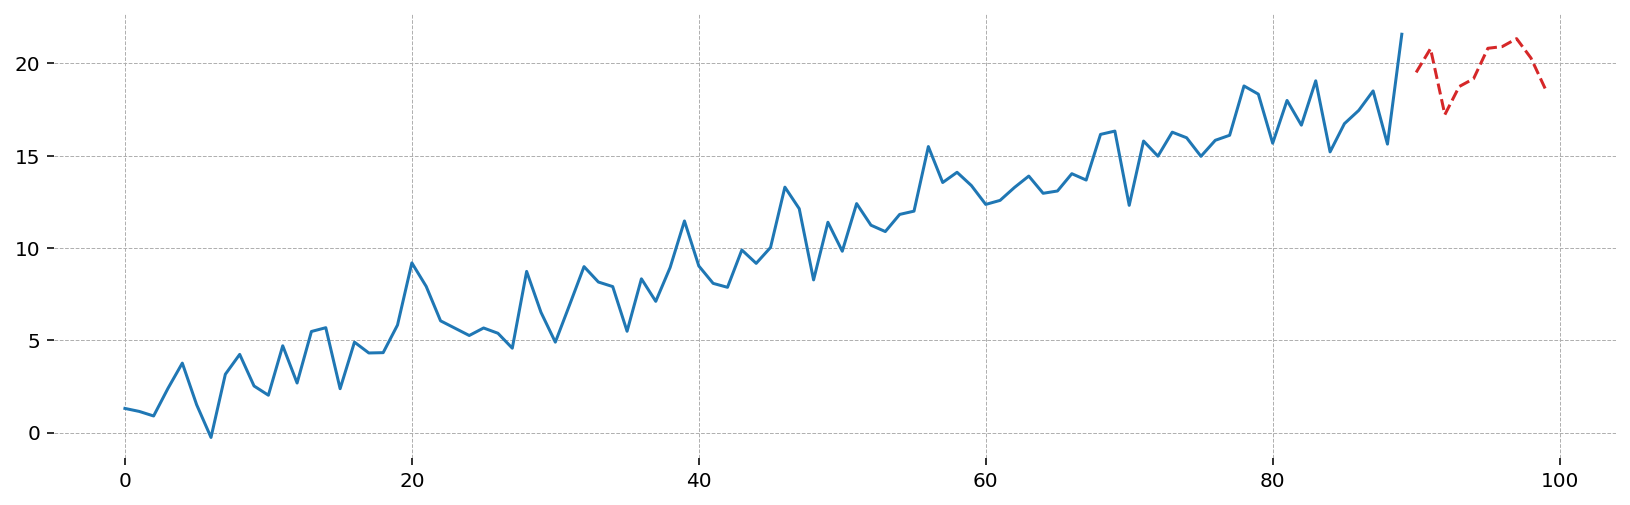

In [3]:
true_alpha = 1
true_gamma = 0.2
true_sigma = 1.5
T = 100

noise = rng.normal(scale=true_sigma, size=T)
t = np.arange(T)
data = true_alpha + true_gamma * t + noise
train_data = data[:90]
test_data = data[-10:]

plt.plot(train_data, color='tab:blue')
plt.plot(np.arange(90, 100), test_data, ls='--', color='tab:red')

In [4]:
with pm.Model() as det_trend:
    t_pt = pm.MutableData('t', t[:90])
    alpha = pm.Normal('alpha')
    gamma = pm.Normal('gamma')
    
    mu = pm.Deterministic('mu', alpha + gamma * t_pt)
    sigma = pm.Exponential('sigma', 1)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=train_data, shape=t_pt.shape)
    idata = pm.sample()

/home/jpp/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, gamma, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [5]:

with det_trend:
    #in-sample 
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    
    #out-of-sample
    pm.set_data({'t':t[-10:]})
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True, predictions=True)

Sampling: [y_hat]


Output()

Sampling: [y_hat]


Output()

/tmp/ipykernel_80814/2490698906.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  time_dim_name = list(idata.observed_data.dims.keys())[0]
/tmp/ipykernel_80814/2490698906.py:10: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  H = list(idata.predictions.dims.values())[-1]
<frozen _collections_abc>:913: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


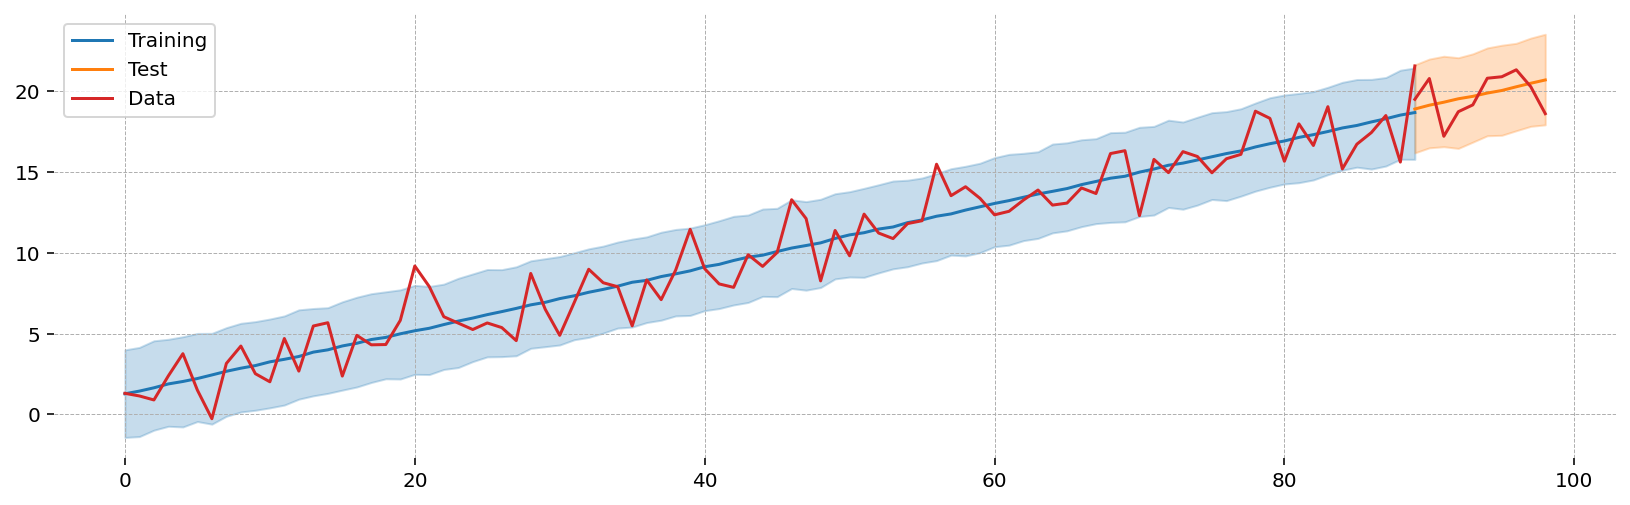

In [6]:
plot_results(idata, test_data)

In [7]:
df = pd.read_csv(r'../data/hsales.csv')

df['index'] = pd.date_range("1973", periods=275, freq='M').strftime('%Y-%m')
df.set_index('index', inplace=True)

# Center and scale the data
df['hsales'] = df['hsales'].transform(lambda x: (x - x.mean()) / x.std())

/tmp/ipykernel_80814/3586368061.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['index'] = pd.date_range("1973", periods=275, freq='M').strftime('%Y-%m')


<Axes: title={'center': 'Sales of new one-family houses, USA'}, xlabel='index'>

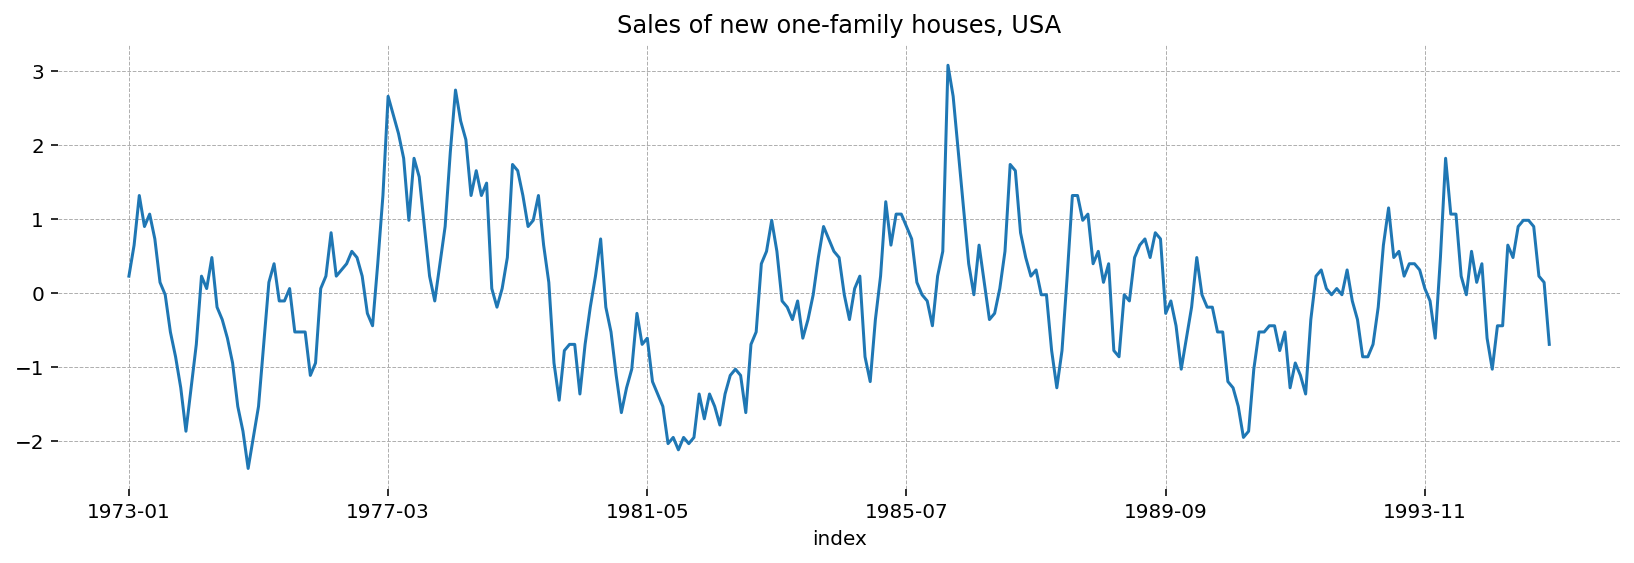

In [8]:
df.plot(legend=False, title='Sales of new one-family houses, USA')

In [9]:
def create_piecewise_trend(t, t_max, n_changepoints):    
    s = pt.linspace(0, t_max, n_changepoints+2)[1:-1]
    A = (t[:, None] > s)*1
    
    return A, s

def create_fourier_features(t, n, p=365.25):
    x = 2 * np.pi * (pt.arange(n)+1) * t[:, None] / p
    return pt.concatenate((pt.cos(x), pt.sin(x)), axis = 1)

def generate_features(t, t_max, n_changepoints=10, n_fourier=6, p=365.25):
    A, s = create_piecewise_trend(t, t_max, n_changepoints)
    X = create_fourier_features(t, n_fourier, p)
    
    return A, s, X

In [10]:
t = np.arange(df.shape[0])
t_max = max(t)
with pm.Model() as prophet_model:
    t_pt = pm.MutableData('t', t)
    A, s, X = generate_features(t_pt, t_max, n_changepoints=10, n_fourier=6, p=12)
    
    initial_slope = pm.Normal('initial_slope')
    initial_intercept = pm.Normal('initial_intercept')
    
    # n_changepoint offsets terms to build the peicewise trend
    deltas = pm.Normal('offset_delta', shape=(10,))
        
    intercept = initial_intercept + ((-s * A) * deltas).sum(axis=1)
    slope = initial_slope + (A * deltas).sum(axis=1)
    
    # n_fourier * 2 seasonal coefficients
    beta = pm.Normal('beta', size=12)
    
    mu = pm.Deterministic('mu', intercept + slope * t_pt + X @ beta)
    sigma = pm.Exponential('sigma', 1)
    y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=df.values.ravel(), shape=t_pt.shape)
    
    idata = pymc.sample()

/home/jpp/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [initial_slope, initial_intercept, offset_delta, beta, sigma]


Output()

In [ ]:
with prophet_model:
    #in-sample 
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    
    #out-of-sample
    last_t = t[-1]
    
    # Forcast 3 years of home sales
    forcast_t = np.arange(last_t, last_t + 36)
    pm.set_data({'t':forcast_t})
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True, predictions=True)

In [ ]:
plot_results(idata, oos_name='Predictions')

In [ ]:
true_sigma = 0.1
noise_sigma = 0.1
T = 100

innovations = rng.normal(scale=true_sigma, size=T)
noise = rng.normal(scale=noise_sigma, size=T)
data = innovations.cumsum() + noise

plt.plot(data)

In [ ]:
with pm.Model() as grw:
    sigma_innov = pm.Exponential('sigma_innov', 1)
    innovs = pm.Normal('innovations', sigma=sigma_innov, size=100)
    
    sigma = pm.Exponential('sigma', 1)
    y_hat = pm.Normal('y_hat', mu=innovs.cumsum(), sigma=sigma, observed=data)
    
    idata = pm.sample(init='jitter+adapt_diag_grad', target_accept=0.99)

In [ ]:
# First the easy part, in-sample prediction
with grw:
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)

n_chains, n_draws, *_ = idata.posterior_predictive.y_hat.values.shape
# Next simulate the recursive model
H = 25
simulations = np.empty((n_chains, n_draws, H))
x0 = data[-1]

simulations[:, :, 0] = x0

# simulate the forward model
for t in range(1, H):
    simulations[:, :, t] = simulations[:, :, t-1] + rng.normal(scale=idata.posterior.sigma_innov) + rng.normal(scale=idata.posterior.sigma)

    
# Add the simulations to the idata in a "predictions" group
# Congrats, you just did a posterior predictive sampling by hand
import xarray as xr
idata.add_groups({'predictions':xr.Dataset(data_vars={'y_hat':(['chain', 'draw', 'y_hat_dim_2'], simulations)},
                                           coords={'chain':np.arange(n_chains),
                                                   'draw':np.arange(n_draws), 
                                                   'y_hat_dim_2':np.arange(T, T+H)})})

In [ ]:
plot_results(idata, oos_name='Forecasts')

In [55]:
extended_data = np.r_[data, np.full(H, np.nan)]

In [56]:
extended_data = np.r_[data, np.full(H, np.nan)]

with pm.Model() as grw:
    sigma_innov = pm.Exponential('sigma_innov', 1)
    innovs = pm.Normal('innovations', sigma=sigma_innov, size=100 + H)
    
    sigma = pm.Exponential('sigma', 1)
    y_hat = pm.Normal('y_hat', mu=innovs.cumsum(), sigma=sigma, observed=extended_data)
    
    idata = pm.sample(init='jitter+adapt_diag_grad', target_accept=0.99)
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)


ValueError: Not enough samples to build a trace.

In [ ]:
fig, ax = plt.subplots()
hdi = az.hdi(idata.posterior_predictive.y_hat).y_hat
mu = idata.posterior_predictive.y_hat.mean(dim=['chain', 'draw']).values
ax.plot(data, color='tab:red', label='Data')
ax.plot(mu[:T], color='tab:blue', label='Training')
ax.fill_between(np.arange(T), *hdi.values.T[:, :T], alpha=0.25, color='tab:blue')

ax.plot(np.arange(T, T+H), mu[T:], color='tab:orange', label='Forecasts')
ax.fill_between(np.arange(T, T+H), *hdi.values.T[:, T:], alpha=0.25, color='tab:orange')


plt.show()

In [ ]:
hdi